In [5]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Point, MultiPoint, LineString
from pprint import pprint

import hydromt

from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel, utils

logger = setuplog("prepare data catalog", log_level=10)

2024-04-17 15:08:22,848 - prepare data catalog - log - INFO - HydroMT version: 0.9.4


### 1. Initialize SfincsModel class, set data catalog and output folder:
Firstly, define some of parameters specific for the model.

In [6]:
model_name = "demo"
grid_size = 100                 # [meter]
dem = "fabdem"                  # name of DEM dataset
constant_river_depth = 2        # [meter]
nr_subgrid_pixels = 4           # []
use_lin_river = False            # whether to infer rivers from DEM or use river dataset
buffer_around_inflow = 5000     # [meter]

Secondly, we load our data library. Hydro-MT datacatalogs use .yml files (similar to dictionaries) to store the filepaths and specifics of datasets. In this case, the data catalog is located in the data folder. References are found in the .yml file. We specify 1 data catalog, but it is also possible to specify multiple, using the list.

In [7]:
data_libs = [
    Path(r"../data/1_static/data_static_tana.yml"),
]
model_root = Path(fr"model/{model_name}")

data_catalog = hydromt.DataCatalog(data_libs=data_libs, logger=logger)

model = SfincsModel(root=model_root, data_libs=data_libs, mode="w+", logger=logger)

2024-04-17 15:08:22,881 - prepare data catalog - data_catalog - INFO - Parsing data catalog from ..\data\1_static\data_static_tana.yml
2024-04-17 15:08:22,900 - prepare data catalog - data_catalog - INFO - Parsing data catalog from ..\data\1_static\data_static_tana.yml
2024-04-17 15:08:22,920 - prepare data catalog - log - DEBUG - Appending log messages to file c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\demo\hydromt.log.
2024-04-17 15:08:22,922 - prepare data catalog - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).


### 2. Configure the time for which the model runs

In [8]:
model.setup_config(
    **{
        "tref":     "20230901 000000",
        "tstart":   "20230901 000000",
        "tstop":    "20231231 000000",
    }
)

print(model.config)

2024-04-17 15:08:22,947 - prepare data catalog - model_api - DEBUG - Setting model config options.
{'mmax': 10, 'nmax': 10, 'dx': 10.0, 'dy': 10.0, 'x0': 0.0, 'y0': 0.0, 'rotation': 0.0, 'latitude': 0.0, 'tref': '20230901 000000', 'tstart': '20230901 000000', 'tstop': '20231231 000000', 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015]}


### 3. Specify characteristics of the wanted grid and generate grid:
Specify the regions, either through a bounding box (bbox) or a shape file. When specifying a grid (either through a bbox or region), the user needs to specify the grid size. This is size is coupled to the coordinate reference system (CRS), meaning that if our reference system uses degrees (long, lat), our grid size should also be defined in degrees. It is best to stick to meters, since subgrids do not work in combination with a grid specified in degrees (may be a bug or feature in the source code of SFINCS). We recommend EPSG:3857, which has global coverage. An example of a more local reference system is EPSG:32737.

Region file found?  True
2024-04-17 15:08:22,989 - prepare data catalog - geodataframe - INFO - Reading  vector data from ..\data\1_static\regions\region_garissa_5km_buffer.geojson


2024-04-17 15:08:23,160 - prepare data catalog - basin_mask - DEBUG - Parsed region (kind=geom): {'geom': 'GeoDataFrame [4402409.89783  -63608.17479 4423462.84213  -39354.37785] (crs = EPSG:3857)'}
{'mmax': 211, 'nmax': 243, 'dx': 100, 'dy': 100, 'x0': 4402410.0, 'y0': -63608.0, 'rotation': 0, 'latitude': 0.0, 'tref': '20230901 000000', 'tstart': '20230901 000000', 'tstop': '20231231 000000', 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 3857}


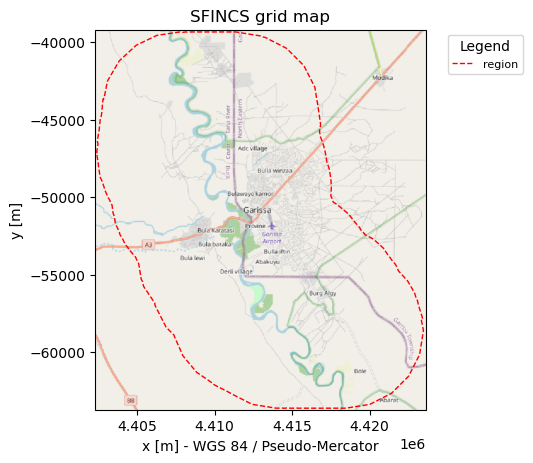

In [9]:
region_path = Path(r"../data/1_static/regions/region_garissa_5km_buffer.geojson")

print("Region file found? ", os.path.isfile(region_path))

model.setup_grid_from_region(
    region={"geom":region_path},
    res=grid_size,
    crs="3857",
)

print(model.config)

_ = model.plot_basemap(variable="grid", plot_region=True, bmap="osm")

### 4. Load in wanted elevation datasets and set the active cells:
We load in a digital elevation model and project it onto the grid. We can specify multiple datasets for different regions or based on threshold values, for example if we use a different dataset for land and sea, we can use a threshold value of 0 meters above sea level.

In [10]:
datasets_dep = [{"elevtn": f"{dem}"}]
model.setup_dep(datasets_dep=datasets_dep)

model.setup_mask_active(mask=region_path, zmin=-5, reset_mask=True)

2024-04-17 15:08:31,349 - prepare data catalog - rasterdataset - INFO - Reading fabdem raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\data\1_static\fabdem\fabdem.tif


2024-04-17 15:08:31,463 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.737, -0.353] (epsg:4326))
2024-04-17 15:08:31,931 - prepare data catalog - merge - DEBUG - Reprojection method of first dataset is: average
2024-04-17 15:08:31,943 - prepare data catalog - geodataframe - INFO - Reading  vector data from ..\data\1_static\regions\region_garissa_5km_buffer.geojson
2024-04-17 15:08:31,970 - prepare data catalog - geodataframe - DEBUG - Clip intersects [39.548, -0.571, 39.737, -0.354] (EPSG:4326)
2024-04-17 15:08:32,003 - prepare data catalog - regulargrid - INFO - 0 gaps outside valid elevation range < 10.0 km2.
2024-04-17 15:08:32,008 - prepare data catalog - sfincs - INFO - Derive region geometry based on active cells.
2024-04-17 15:08:32,021 - prepare data catalog - model_api - WARNING - Replacing geom: region


### 5. Add river inflow/outflow points:
We add hydrography data. We base this either on flow directions that are inferred from the DEM, or on a global river centerlines dataset.

2024-04-17 15:08:32,064 - prepare data catalog - rasterdataset - INFO - Reading merit_hydro raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\data\1_static\merit_hydro\{variable}.tif


2024-04-17 15:08:32,097 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\data\1_static\merit_hydro\flwdir.tif
2024-04-17 15:08:32,124 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\data\1_static\merit_hydro\uparea.tif
2024-04-17 15:08:32,153 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.737, -0.353] (epsg:4326))
2024-04-17 15:08:37,401 - prepare data catalog - sfincs - INFO - Found 2 river inflow points.


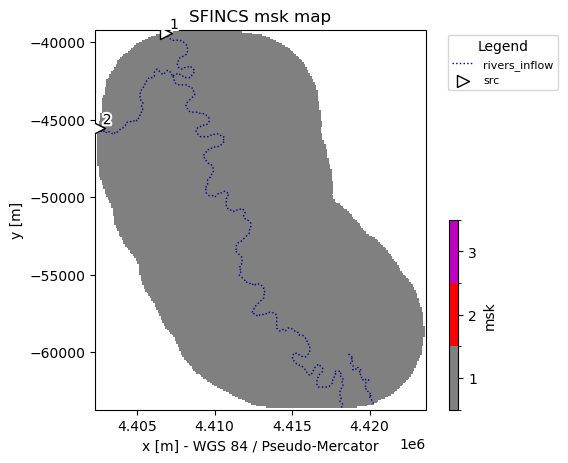

In [11]:
river_len = 100 # km
river_upa = 100 # km2
river_width = 150 # m

# We load in the Lin et al. dataset
if use_lin_river:
    centerlines = data_catalog.get_geodataframe("rivers_lin2019_v1")
    model.setup_river_inflow(
        rivers = centerlines,
        reverse_river_geom = True,
        keep_rivers_geom=True,
    )

else:
    model.setup_river_inflow(
        hydrography="merit_hydro", 
        river_len=river_len, 
        river_upa=river_upa, 
        river_width=river_width, 
        keep_rivers_geom=True
    )

fig, ax = model.plot_basemap(variable="msk", plot_bounds=True)

### 6. Update mask with water level and outflow boundary cells - including use of polygons:
We add the outflow boundary after adding the river, since the river removes adjacent boundaries upon generation. If we would have a water level boundary (e.g., sea), we also specify that here, for example through the use of an ocean mask (in our data catalog based on OpenStreetMap).

2024-04-17 15:08:38,103 - prepare data catalog - regulargrid - DEBUG - outflow (mask=3) boundary cells reset.


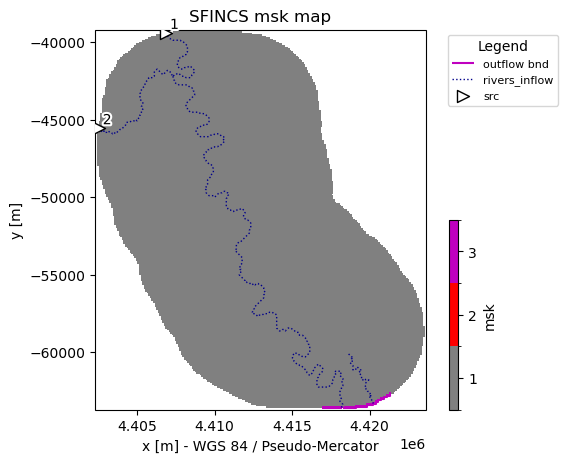

In [12]:
model.setup_mask_bounds(btype="outflow", zmax=135, reset_bounds=True)
# model.setup_mask_bounds(btype="waterlevel", include_mask="osm_coastlines", reset_bounds=True)

fig, ax = model.plot_basemap(variable="msk", plot_bounds=True)

### 7. Add spatially varying roughness data, burn river into DEM, create subgrid.
Select a roughness data set. "vito" is the name of a dataset in the datacatalog. We can specificy land-use/land-cover, or other proxies for roughness, but in that case we also need to specify a reclass table that maps these to roughness coefficients.

In [13]:
datasets_rgh = [{"lulc": "vito"}]

Add specific river bathymetry data. We need to specify depths, river roughness, and widths. Instead of specifying a constant (or segment) width, we use a global river mask (also found in data catalog).

In [14]:
gdf_riv = model.geoms["rivers_inflow"].copy()

riv_depth = constant_river_depth
riv_manning = 0.03

datasets_riv = [{"centerlines": gdf_riv, "mask":"grwl_mask_vector", "rivdph":riv_depth, "manning":riv_manning}]

We generate a subgrid. We never need more subgrid pixels than the amount it takes to capture the highest resolution data. For example, if our grid size is 100 meters and our highest-res data has a resolution of 20 meters, there is no need to use more than 5 subgrid pixels.

2024-04-17 15:08:38,729 - prepare data catalog - rasterdataset - INFO - Reading fabdem raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\data\1_static\fabdem\fabdem.tif
2024-04-17 15:08:38,769 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.737, -0.353] (epsg:4326))
2024-04-17 15:08:38,783 - prepare data catalog - rasterdataset - INFO - Reading vito raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\data\1_static\landuse\landuse_vito_tana1.tif
2024-04-17 15:08:38,841 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.737, -0.353] (epsg:4326))
2024-04-17 15:08:38,846 - prepare data catalog - dataframe - INFO - Reading  csv data from c:\Users\pjdeb\anaconda3\envs\sfincs\lib\site-packages\hydromt_sfincs\data\lulc\vito_mapping.csv


The nodata value None is not in the reclass table.None will be used for the params.


2024-04-17 15:08:38,915 - prepare data catalog - geodataframe - DEBUG - Clip intersects [4401410.000, -64608.000, 4424510.000, -38308.000] (EPSG:3857)
2024-04-17 15:08:38,937 - prepare data catalog - geodataframe - INFO - Reading grwl_mask_vector vector data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\data\1_static\grwl_rivermask\grwl_mask_vector_tana.gpkg


2024-04-17 15:08:39,950 - prepare data catalog - geodataframe - DEBUG - Clip intersects [4402410.000, -63608.000, 4423510.000, -39308.000] (EPSG:3857)
2024-04-17 15:08:39,989 - prepare data catalog - subgrid - INFO - Number of regular cells in a block : 500
2024-04-17 15:08:39,990 - prepare data catalog - subgrid - INFO - Number of blocks in n direction    : 1
2024-04-17 15:08:39,992 - prepare data catalog - subgrid - INFO - Number of blocks in m direction    : 1
2024-04-17 15:08:39,993 - prepare data catalog - subgrid - INFO - Grid size of flux grid            : dx=100.0, dy=100.0
2024-04-17 15:08:39,995 - prepare data catalog - subgrid - INFO - Grid size of subgrid pixels       : dx=25.0, dy=25.0
2024-04-17 15:08:39,997 - prepare data catalog - subgrid - INFO - block 1/1 -- col 0:210 | row 0:242
2024-04-17 15:08:40,225 - prepare data catalog - subgrid - DEBUG - Burn rivers in bathymetry and manning data
2024-04-17 15:08:41,588 - prepare data catalog - subgrid - DEBUG - Processing sub

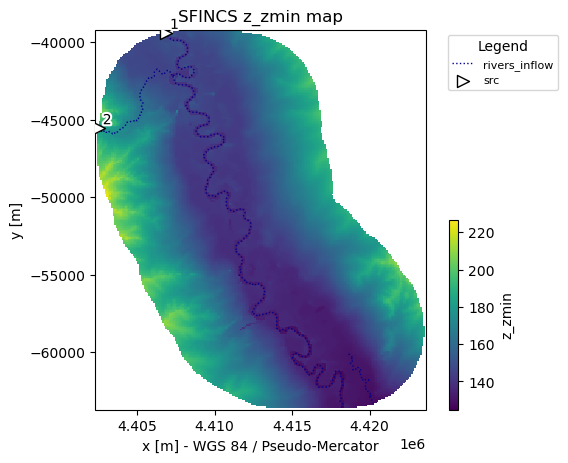

In [15]:
model.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_rgh=datasets_rgh,
    datasets_riv=datasets_riv,
    nr_subgrid_pixels=nr_subgrid_pixels,
    write_dep_tif=True,
    write_man_tif=False,
)
# uncomment to see the subgrid table variales
# sf.subgrid

# we can plot the 2D subgrid variables
_ = model.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, zoomlevel=12
)

### 8. Add spatially varying infiltration data:

We use spatially vayring infiltration data based on curve numbers.

In [16]:
model.setup_cn_infiltration("gcn250", antecedent_moisture="avg")

2024-04-17 15:08:55,227 - prepare data catalog - rasterdataset - INFO - Reading gcn250 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\data\1_static\gcn250\{variable}.tif


2024-04-17 15:08:55,374 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.737, -0.353] (epsg:4326))


### 9. Add an upstream discharge time-series as forcing:
Firstly, we load in discharge data. We clip this to the start and stop time of the model that we specified at the start. We then create a dataframe which contains the same columns as our inflow points and are indexed with timesteps.

Text(0, 0.5, 'discharge [m3/s]')

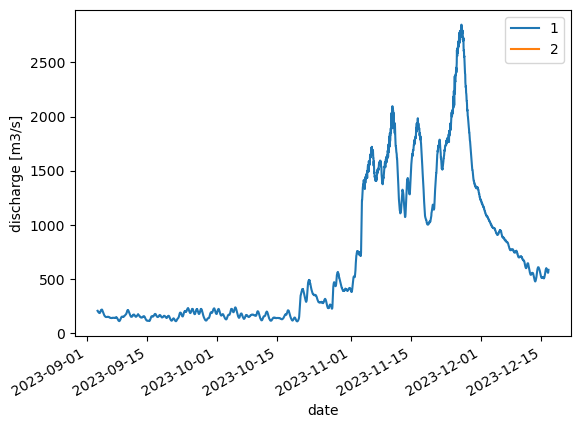

In [17]:
fpath_dis = Path(r"C:/Users/pjdeb/OneDrive/Documenten/Universiteit/CT 5/MDP/data_sens/wra/clean_data_mats/fixed_all_data_Garissa.csv")

discharge_garissa = pd.read_csv(fpath_dis, parse_dates=['date'], index_col='date')
discharge_garissa.index = pd.to_datetime(discharge_garissa.index, format="mixed")

start_date = pd.to_datetime(model.config["tstart"])
end_date = pd.to_datetime(model.config["tstop"])

discharge_garissa = discharge_garissa[(discharge_garissa.index >= start_date) & (discharge_garissa.index <= end_date)]
index = model.forcing["dis"].index
dis = pd.DataFrame(index=discharge_garissa.index, columns=index)

dis[1] = discharge_garissa["discharge[m3/s]"]

dis.plot()
plt.ylabel("discharge [m3/s]")

# use this when you want to generate an image without values, if data is sensitive.
# plt.yticks([])

The forcing now has the correct format to be used as input for SFINCS. We use a buffer of 1000 meter to make sure that discharge can not enter the domain and then immediately flow out of the domain 1 meter to the side.

In [18]:
model.setup_discharge_forcing(timeseries=dis, buffer=5000)

2024-04-17 15:08:56,824 - prepare data catalog - dataframe - DEBUG - Slicing time dime (datetime.datetime(2023, 9, 1, 0, 0), datetime.datetime(2023, 12, 31, 0, 0))
2024-04-17 15:08:56,871 - prepare data catalog - model_api - WARNING - Replacing forcing: dis


### 10. Add observation points (water level) and lines (discharge):
We set up opservation points. In this case, we use the location of the water-level gauge in Garissa. We can also specify cross-sections (lines) to measure discharge. Since we only use one river, we do not consider this here, since discharge distribution is of less interest.

In [19]:
garissa_gauge_coords = 39.636760, -0.463964    # EPSG: 4326

observation_points = {'station': ['garissa'], 'geometry': [Point(garissa_gauge_coords).reverse()]}
gdf = gpd.GeoDataFrame(observation_points, crs="EPSG:4326")
model.setup_observation_points(
    locations=gdf, merge=False)

2024-04-17 15:08:56,903 - prepare data catalog - geodataframe - DEBUG - Clip intersects [4402410.000, -63608.000, 4423510.000, -39308.000] (EPSG:3857)


### 11. Save all files

In [20]:
model.write()

# Show created files in folder:
dir_list = os.listdir(model.root)
print(dir_list)
print(model.config)

2024-04-17 15:08:56,925 - prepare data catalog - sfincs - INFO - Writing model data to c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\demo
2024-04-17 15:08:56,926 - prepare data catalog - sfincs - DEBUG - Write binary map indices based on mask.
2024-04-17 15:08:56,933 - prepare data catalog - sfincs - DEBUG - Write binary map files: ['msk', 'dep', 'scs'].
2024-04-17 15:08:57,002 - prepare data catalog - sfincs - INFO - Write raster file(s) for grid to 'gis' subfolder
2024-04-17 15:08:57,133 - prepare data catalog - sfincs - INFO - Write geom files
2024-04-17 15:08:57,137 - prepare data catalog - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2024-04-17 15:08:57,182 - prepare data catalog - sfincs - INFO - Write forcing files
2024-04-17 15:08:57,214 - prepare data catalog - sfincs - INFO - Write vector file(s) for forcing.dis to 'gis' subfolder
2024-04-17 15:08:57,242 - prepare data catalog - sfincs - WARNING - zsini not in states, skipp

### 12. Show final model

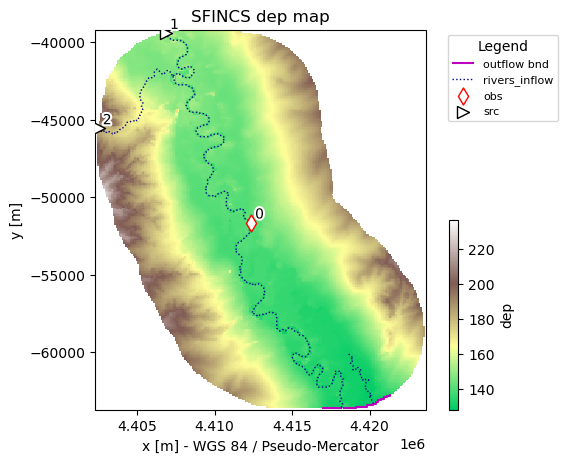

In [21]:
_ = model.plot_basemap(fn_out="basemap.png", zoomlevel=12)

plt.savefig(Path(fr"figs/{model_name}"))